# deSpoelberch01218453
# Coursework 2

In this coursework, we train, and tune, different types of estimators or neural networks to classify used cars for a dealership. The aim is to explore, and analyse the different classifiers, and how different hyper parameters affect performances and our models. Finally, we will look at the suitability of these classifiers for different tasks.

## Preliminaries

* Prepare and clean data 
* Balance dataset
* Standardise descriptors

In [410]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [458]:
data = pd.read_csv('train_set.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

test_data = pd.read_csv('test_set.csv')
test_data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,buying,maint,doors,persons,lug_boot,safety,rating
0,low,med,3,4,small,high,good
1,vhigh,vhigh,2,2,small,low,good
2,med,med,5more,4,med,high,good
3,low,med,3,4,small,high,unacc
4,vhigh,vhigh,2,2,small,low,unacc


In [459]:
encode = {
    'low':0, 'small':0, 'unacc':0,
    'med':1, 'acc':1,
    'high':2, 'big':2, 'good':2,
    'vhigh':3, 'vgood': 3,
    '5more': 5, 'more':5
}

for c in list(data.columns):
    data[c] = data[c].apply(lambda x: encode[x] if len(str(x)) > 1 else x)
    test_data[c] = test_data[c].apply(lambda x: encode[x] if len(str(x)) > 1 else x)
data.head()

,buying,maint,doors,persons,lug_boot,safety,rating
0,0,1,3,4,0,2,2
1,3,3,2,2,0,0,2
2,1,1,5,4,1,2,2
3,0,1,3,4,0,2,0
4,3,3,2,2,0,0,0


In [413]:
rating_counts = data.rating.value_counts()
max_no = max(rating_counts)

df_0 = data[data['rating'] == 0].sample(max_no, replace=True).reset_index().drop(columns=['index'])
df_1 = data[data['rating'] == 1].sample(max_no, replace=True).reset_index().drop(columns=['index'])
df_2 = data[data['rating'] == 2].sample(max_no, replace=True).reset_index().drop(columns=['index'])
df_3 = data[data['rating'] == 3].sample(max_no, replace=True).reset_index().drop(columns=['index'])

bdata = pd.concat([df_0, df_1, df_2, df_3]).reset_index(drop=True)
bdata = bdata.sample(frac=1).reset_index(drop=True)

In [460]:
attributes = list(data.columns)[:-1]

y = bdata['rating']
X = pd.DataFrame(preprocessing.scale(bdata[attributes]), columns=attributes)
y_test = test_data['rating']
X_test = pd.DataFrame(preprocessing.scale(test_data[attributes]), columns=attributes)
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,1.510305,-0.151171,0.373235,-2.234381,-1.446982,-0.571291
1,-0.991045,0.800208,0.373235,0.849669,-0.172368,0.835041
2,1.510305,-1.102550,-0.549996,0.849669,-0.172368,-0.571291
3,-0.991045,-1.102550,-0.549996,0.849669,-0.172368,-0.571291
4,-0.991045,1.751587,1.296466,0.849669,-0.172368,-0.571291


## **Task 1**
**Train a random forest classifier on the training set to optimise the accuracy of your validation predictions using 5-fold stratified cross validation. You should use the 5-fold cross validation to explore and optimise over suitable ranges the following hyperparameters: (i) number of decision trees; (ii) depth of trees, (iii) maximum number of descriptors (features) randomly chosen at each split.**

Note: Although other measures of performance, such as precision, recall, etc, could (and should) be used for comparison, here we only concentrate on accuracy for simplicity. Explain and document your choice for the best RF model. Explain which of the hyperparameters have a bigger impact on performance. Base your answer on computations and explain in relation to the mathematical basis of the algorithm.

First, we create a list of potential hyperparameters, using sensible ranges. We then feed those into our gridsearch, a method that uses searches for optimal parameters using 5-fold stratified cross validation. 

In [415]:
no_trees = np.linspace(start=1, stop=200, num=20, dtype=np.int64)
depths = list(np.linspace(start=1, stop=50, num=10, dtype=np.int64))
depths.append(None)
max_no_descriptors = [1, 2, 3, 4, 5, 6]
param_grid = {
    'n_estimators': no_trees,
    'max_depth': depths,
    'max_features': max_no_descriptors
}

In [418]:
rf = RandomForestClassifier()

best_rf = GridSearchCV(rf, param_grid, n_jobs=-1, cv=5, verbose=0)
best_rf.fit(X,y)

print("best params: ", best_rf.best_params_)
print("best acc: ", best_rf.best_score_)

best params:  {'max_depth': 11, 'max_features': 2, 'n_estimators': 32}
best acc:  0.3983985765124555


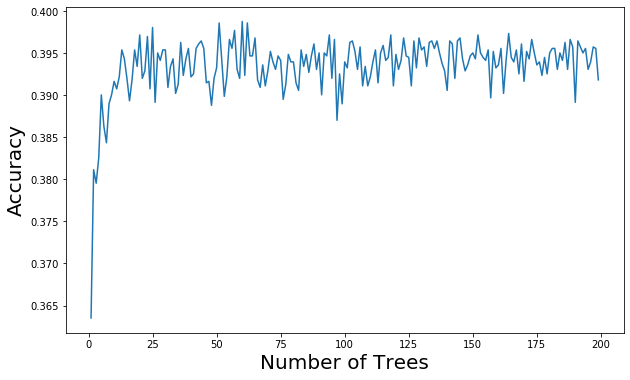

In [419]:
#graph change in accuracy over differing number of trees in the forest
accs = []
for i in range(1, 200):
    rfc = RandomForestClassifier()
    rf_no_tree = GridSearchCV(rfc, {'n_estimators': [i], 'max_depth': [10], 'max_features': [2]}, n_jobs=-1, cv=5, verbose=0)
    rf_no_tree.fit(X,y)
    accs.append(rf_no_tree.best_score_)

plt.figure(figsize=(10,6))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Number of Trees', fontsize=20)
plt.plot(range(1, 200), accs)
plt.show()

### Discussion on Parameters
As seen in lectures, and on the graph above, once the number is sufficiently high (about 25 in this case), the number of trees doesn't affect the training accuracy all that much. To some extent, the number of trees you will want will depend on the max number of features per tree as you want to avoid too much correlation between trees.  

Max depth depends on the max number of features per tree, as well as the amount of unique values per attribute. Since our optimal max number of features is 2, it makes sense that the trees won't be too complicated and deep. 

As such, we want to look at the max number of features per tree as the most important hyper-parameter. We're looking for a number that isn't too large otherwise most of the trees would be correlated. A smaller number of selected features will therefore lead to more stability. We find 2 features as optimal, which follows the rule of thumb for classification: take the square root of the number of features (6, here). This parameter being relatively small is also very important if some features are more important than others because the "unimportant" features don't get overshadowed on every tree, and can also bring some use.

## **Task 2**
**Train a support vector machine (SVM) on your training data using three different kernel functions: (i) linear; (ii) polynomial, (iii) RBF. Each of those kernels have a few hyperparameters which you should explore and tune using 5-fold cross validation to find the kernel (and hyperparameters) with the highest validation accuracy. Explain and document your choice for the best SVM model (kernel and hyperparameters) for our data. Base your answer on computations and give explanations related to the mathematical basis of the algorithm**

Similarly to Task 1, we list our hyperparameters to ready them for a gridsearch. We'll have differing parameters for different kernels so we have to make 3 grids:

In [441]:
sv = SVC()

linear_grid = {
    'kernel': ['linear'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

rbf_grid = {
    'kernel': ['rbf'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

poly_grid = {
    'kernel': ['poly'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'degree': [1,2,3, 4, 5],
    'gamma': ['scale', 'auto']
}

**Linear kernel**

In [437]:
best_lin = GridSearchCV(sv, linear_grid, n_jobs=-1, cv=5, verbose=0)
best_lin.fit(X,y)
print("best parameters: ", best_lin.best_params_)
print("best training accuracy: ", best_lin.best_score_)

best parameters:  {'C': 1, 'kernel': 'linear'}
best training accuracy:  0.3491103202846975


**Polynomial kernel**

In [442]:
best_poly = GridSearchCV(sv, poly_grid, n_jobs=-1, cv=5, verbose=2)
best_poly.fit(X,y)
print("best parameters: ", best_poly.best_params_)
print("best training accuracy: ", best_poly.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


best parameters:  {'C': 100, 'degree': 5, 'gamma': 'auto', 'kernel': 'poly'}
best training accuracy:  0.37615658362989324


**RBF kernel**

In [438]:
best_rbf = GridSearchCV(sv, rbf_grid, n_jobs=-1, cv=5, verbose=0)
best_rbf.fit(X,y)
print("best parameters: ", best_rbf.best_params_)
print("best training accuracy: ", best_rbf.best_score_)

best parameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
best training accuracy:  0.3925266903914591


### Discussion

The only parameter to tune for the linear kernel is C. C is the penalty parameter of the error term. The lower the C, the less it matters if we misclassify a value. It controls the trade off between having large margins (low C), and classifying the training points correctly (high C). Because we're using accuracy as a score, we will tend to get a high C to correctly classify as many samples as possible. A C of 1 implies we can keep a reasonable margin, and that our classes must be well grouped. Nevertheless, we don't get an amazing accuracy. 

This doesn't seem to be due to the linearity of it because our next kernel, the polynomial one, doesn't perform much better. Obviously, it performs equivalenty to linear or better using optimal parameters because a polynomial kernel with a degree parameter of 1 is equal to a linear. We get a really high C (100), and degree is equal to 5. The degree parameter defines the dimension of the hyperplane we're going to use to split the data. The risk of going to high degrees is that we will overfit the data. The gamma parameter, one that defines how far ranging the influence of a single datapoint is, and thus the wigliness (overfitting) of the class boundaries, is set to auto which is defined as 1/no_features. We get an accuracy of 37% on the training set which is the slightest improvement to our linear kernel. 

Finally, our RBF kernel performs best, with a small improvement to the polynomial kernel. With a C of 10, we probably don't have the best margins, encouraging more complicated decision boundaries. Our gamma parameter is 1.

Time permitting, I would have liked to tune a few more values for the polynomial kernel but the gridsearch was taking more than 24h to run so I limited my gamma parameter to auto and scale.

## **Task 3**
**In Task 3, you will explore how a feed-forward neural network performs on the training set. Using Pytorch, train a neural network to classify each car in the training set based on the given descriptors. Setup of the network: Your network should have two hidden layers, each with 200 neurons. You should use ReLU as your activation function. Fix the optimisation method to be stochastic gradient descent (SGD), and define the loss function as cross-entropy. You should train on batches of 64 data points with a learning rate of 0.01 for 120 epochs.**


In [315]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

In [316]:
#prepare the data for pytorch
def get_loader(df):
    Xs = pd.DataFrame(preprocessing.scale(df[attributes]))
    Xs = torch.from_numpy(Xs.values).float()
    ys = df['rating']
    ys = torch.from_numpy(np.array(ys.values))
    
    return torch.utils.data.TensorDataset(Xs, ys)

In [317]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout, f):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.f = f
    
    def forward(self, x):
        out = self.f(self.fc1(x))
        out = self.f(self.fc2(out))
        out = self.dropout(out)
        out = self.f(self.fc3(out))
        out = self.fc4(out)
        return out

In [318]:
def train_analysis(data, batch_size = 64, learning_rate=0.01, num_classes=4, input_size = 6,
                   hidden_size = 200, num_epochs=120, dropout=0, deep=False,graph=True, func=F.relu):

    #Prepare data
    train_tensor = get_loaders(data)
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size)

    #Create net
    if deep:
        net = DeepNN(input_size, hidden_size, num_classes, dropout)
    else:
        net = NeuralNet(input_size, hidden_size, num_classes, dropout, func)
        
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)

    #Train net
    loss_values = []
    total_step = len(train_loader)

    for _ in range(num_epochs):

        net.train()
        train_loss = 0.0

        for Xs, ys in train_loader:
            
            # forward pass
            outputs = net(Xs)
            loss = criterion(outputs, ys)
            
            # backward and optimise
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            train_loss += loss.item()

        loss_values.append(train_loss / total_step)

    if graph:
        plt.figure(figsize=(12,8))
        plt.ylabel('Training Loss', fontsize=20)
        plt.xlabel('Epoch', fontsize=20)
        plt.plot(range(len(loss_values)), loss_values)
        plt.show()
     
    return net


def measure_accuracy(net, test_data):
    
    test_tensor = get_loader(test_data)
    test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=batch_size)
    
    #Calculate Accuracy
    net.eval()
    correct = 0
    total = 0
    for Xs, ys in test_loader:
        outputs = net(Xs)
        _, predicted = torch.max(outputs.data, 1)
        total += ys.size(0)
        correct += (predicted == ys).sum().item()
    return correct/total

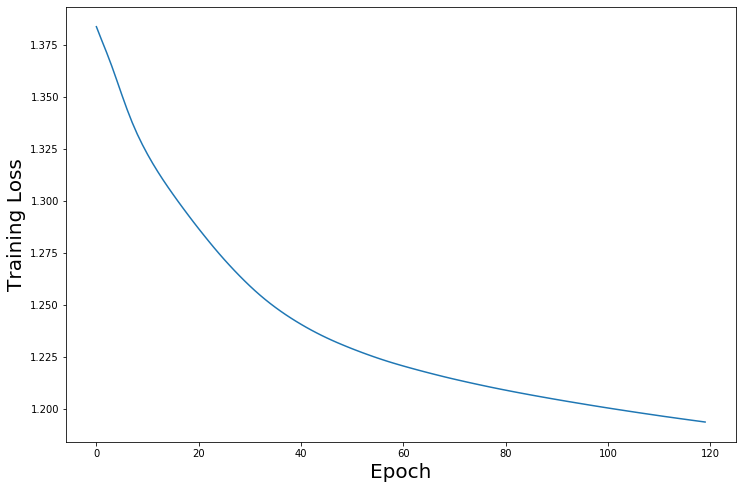

In [319]:
net = train_analysis(bdata)

### **3.1** 
**Show and document how changing the learning rate to: (i) 0.0005 and (ii) 0.95 leads to poor convergence.**

(i): Learning rate of 0.0005


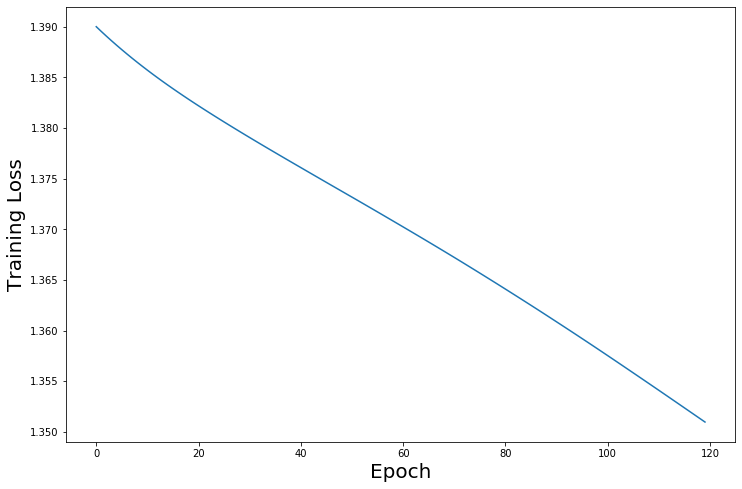

In [334]:
print('(i): Learning rate of 0.0005')
net = train_analysis(bdata, learning_rate=0.0005)

(i): Learning rate of 0.95


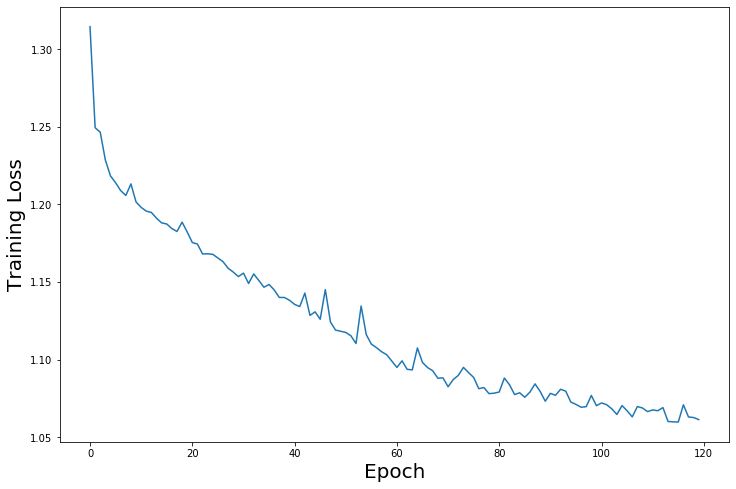

In [335]:
print('(i): Learning rate of 0.95')
net = train_analysis(bdata, learning_rate=0.95)

The learning rate is how much we are adjusting weights with respect to our loss gradients. A lower rate means we follow the downward gradient more slowly whereas a higher rate means we give more importance to the gradient and move fast. We see this happen in our graphs for learning rates of 0.0005, and 0.95.

In (i), our learning rate is really small so we take tiny steps at every weight update. Looking at the graph, this makes sense: we're constantly moving in the right direction (i.e. our loss is decreasing) but it is doing so **very slowly**; by epoch 120, our training loss isn't below 1.34. In (ii), our really big learning rate means we put a lot of stock into the gradients we derive and we see our loss drop quickly. Notice that we are immediately below a loss of 1.3.

In (ii), we don't get a smooth curve. This is because of our high learning rate; sometimes we "overshoot". This is in the case where we want to move down a gradient, but because of the high learning rate, actually go past our objective. This tends to happen when you start nearing your optimal training loss. It's the downside of a high learning rate: it's hard to reach the global minimum because you're often oscillating around it. In (i), even though we don't have time to reach the minimum in 120 epochs, we would see that it would approach the minimum slowly and smoothly, without overshooting.

A downsides of a small learning rate is that we could get stuck in local minimums. Because we never take big steps, if a local minimum is deep enough, we would manage to get out of it and every gradient descent would point towards the local minimum. With a high learning rate, this isn't as much of a risk as you'll often take big enough step to leave the well.

### **3.2**
**Show and document how changing the batch size to: (i) 2 and (ii) 256 leads to poor convergence
and performance. Explain the reasons.**

(i) Batch size of 2


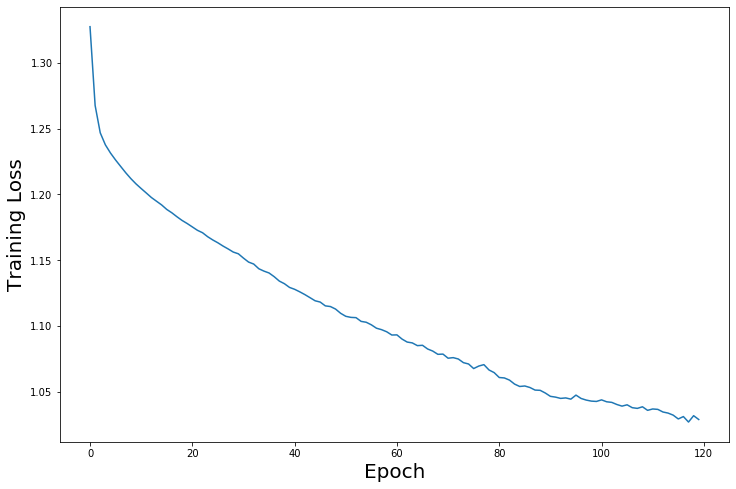

This took 181.736s


In [462]:
import time

print('(i) Batch size of 2')
start = time.time()
net = train_analysis(bdata, batch_size=2)
print(f'This took {round(time.time()-start, 3)}s')

(ii) Batch size of 256


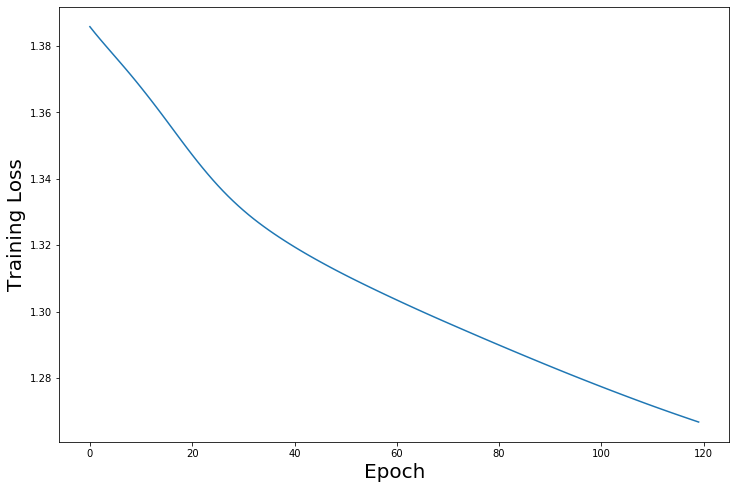

This took 6.937s


In [463]:
print('(ii) Batch size of 256')
start = time.time()
net = train_analysis(bdata, batch_size=256)
print(f'This took {round(time.time()-start, 3)}s')

When you take a batch size of 2, the neural net takes a lot longer to train. (i) took over 3 minutes to train whereas a batch size of 256 in (ii) took 7 seconds. This is because the computationally demanding bit of training a neural net is the back propagation. Since you back propagate once per batch per epoch, changing the batch size to a small value (i.e. 2) means you'll have to do this computationally intensive step a lot more times because you're still using the same amount of training data.

Nevertheless, because we're using SGD, we're "correcting ourselves on the way" instead of only at the end of the epoch like standard Gradient Descent. As such, using small batch sizes (i.e. 2) means we're finding many more (approximated) directions to go down. As such, the first few epochs show tremendous improval in loss (as seen in the graph (i)). For example, using batch size=2, we get down to an approximate training loss of 1.2 by epoch 10 whereas we don't even get there with batch_size=256 in 120 epochs.

Even though our initial convergence in (i) is great, by the end we see our curve wiggle a bit. This is because once we get close to our final convergence, a small batch size will have gradient vectors that start going in very different directions because the batches have more variability. This won't happen with larger batches but it will take more epochs to reach the point of final convergence.

### **3.3**
**In Pytorch, implement dropout regularisation to the second layer of the NN, and tune the dropoutrate to optmise the validation accuracy of the NN.**

The highest accuracy obtained is with a dropout rate of 0.28 and is 0.3818505338078292


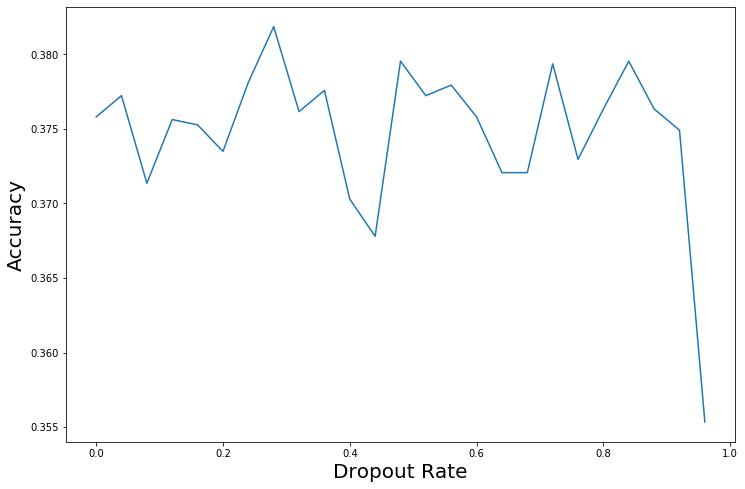

In [466]:
dropouts = np.linspace(0, 1, num=25, endpoint=False)
accuracies = []

folds = StratifiedKFold(n_splits=5, shuffle=True)
folds.get_n_splits(X, y)

for d in (dropouts):
    
    folds_acc = []
    
    for train_index , test_index in folds.split(X, y):
        
        net = train_analysis(bdata.iloc[train_index], dropout=d, graph=False)
        acc = measure_accuracy(net, bdata.iloc[test_index])
        
        folds_acc.append(acc)
        
    mean_acc = np.mean(folds_acc)
    accuracies.append(mean_acc)
  
plt.figure(figsize=(12,8))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Dropout Rate', fontsize=20)
plt.plot(dropouts, accuracies)

max_ind = np.argmax(accuracies)
print(f'The highest accuracy obtained is with a dropout rate of {dropouts[max_ind]} and is {accuracies[max_ind]}')

**Explain and document your choice for the best NN model (dropout rate) for the given architecture basing your answer on computations and on explanations related to the mathematical basis of the algorithm.**

By randomly dropping out nodes during training, we add some noise to the training and can avoid overfitting by being able to generalise. Because we oversampled quite a lot, this is a risk as many entries in classes 1, 2, and 3 will be repeated and we want to avoid our net from just "memorising" these specific cases. In the graph above, we find the optimal dropout rate for layer 2 is: p = 28%. Because dropout adds some non-determinism to results, we do a five-fold cross-validation.

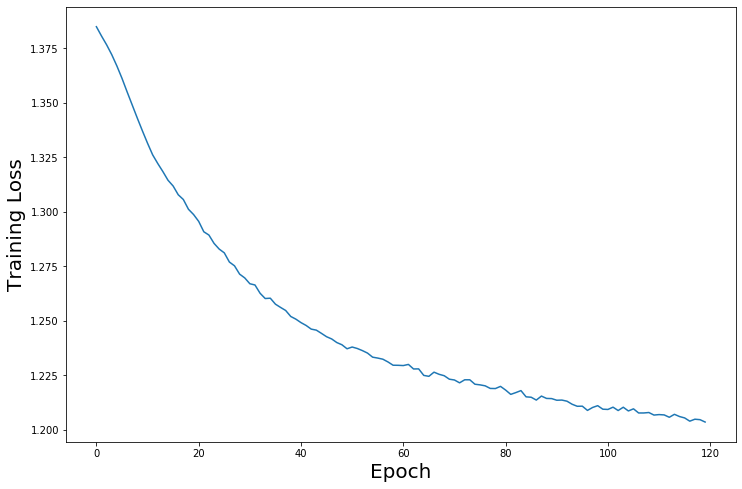

In [336]:
best_net = train_analysis(bdata, dropout=dropouts[max_ind])

## **Task 4**
### **4.1** 
***Compare the performance of the three classifiers you have obtained in Tasks 1, 2 and 3 by applying them to the test data set. You should report the accuracy, recall, precision, and F1 score and any other relevant score derived from the confusion matrix. Examine your results in relation to the performance obtained for the training set.***

In [393]:
test_tensor = get_loader(test_data)
test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=batch_size)

def test_net(net):
    net.eval()
    pred = []
    actual= []
    for Xs, ys in test_loader:
        outputs = net(Xs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            pred.append(p)
        for y in ys:
            actual.append(y)
    return actual, pred

In [444]:
from sklearn.metrics import confusion_matrix, classification_report

def present_results(name, actual, pred):
    print("Best " + name)
    print("Confusion Matrix:")
    print("    0   1   2   3")
    print(confusion_matrix(actual, pred))
    print(classification_report(actual, pred))
    print("#######################################################\n")

    
# Dictionary of classifiers to examine    
classifiers = {"Random Forest": best_rf, 
               "RBF Kernel SVM": best_rbf}

#Examine classifiers
for key, classifier in classifiers.items():
    pred = classifier.predict(X_test)
    present_results(key, y_test, pred)

#Examine our best neural network
actual, pred = test_net(best_net)
present_results("Neural Net", actual, pred)

Best Random Forest
Confusion Matrix:
    0   1   2   3
[[278  52  42  40]
 [ 17  75  49  47]
 [ 20  58  82  44]
 [ 11  38  54  85]]
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       412
           1       0.34      0.40      0.36       188
           2       0.36      0.40      0.38       204
           3       0.39      0.45      0.42       188

    accuracy                           0.52       992
   macro avg       0.49      0.48      0.48       992
weighted avg       0.57      0.52      0.54       992

#######################################################

Best RBF Kernel SVM
Confusion Matrix:
    0   1   2   3
[[262  56  48  46]
 [ 14  60  63  51]
 [ 18  57  78  51]
 [ 13  35  58  82]]
              precision    recall  f1-score   support

           0       0.85      0.64      0.73       412
           1       0.29      0.32      0.30       188
           2       0.32      0.38      0.35       204
           3       0.36   

### Discussion

Here, we apply our most performant RF, our RBF-kernel SVM, and our best neural net to the test data. It's important to notice that the test dataset is unbalanced. Like our initial training data, class 0 is over-represented. 

For every metric, our RF outperforms the SVM. It is more precise, and has better recall for every class. Similarly, our Neural Net has got our SVM beat in terms of precisions (less FPs). It also has a higher average recall (less FNs), and average accuracy.

Comparing our RF and our NN, we find our NN is more precise for every class. Nevertheless, we find our RF has better recall for class 0, the unacceptable cars. By that, we mean that our RF is better at picking out unacceptable cars. In terms of f1, our RF outperforms our NN for classes 0, and 2 but the NN has an overall better weighted f1 (taking into account the class inbalance of the test set).

Curiously, we find that all 3 of our classifiers get better accuracies on the test set rather than the training data. I attribute this to the fact that our test set is inbalanced and that our classifiers are really good with the majority class of the set.

### **4.2** 
**Discuss the suitability of each of the three methods for our task. Comment on their generalizability to the test data, computational cost, and the appropriateness given the dimensionality of the data and any other insights based on your study of the descriptors of the data set. You should base your evaluations on evidence and computations.**

My decision on what method to use would depend on my end goal. If, as a salesman, I want to give customers a guarantee that the car I'm selling is **not** unacceptable, then I would use our random forest because it has a better chance of picking out unacceptable vehicles. If, instead, I'm looking for classifying as accurately as possible, I would use our NN as, overall, it outperforms the RF. In no case would I use the SVM as it was inferior on most levels.

As mentioned above, our classifiers score better on the test data but that is probably due to the class distribution of the test set (412, 188, 204, 188).

I believe that SVM aren't particularly adapted to the task. This is due to two things. First of all, using kernel tricks makes you assume things about your data. Secondly, we only have 6 attributes to train on. While this is great place for RFs, SVMs are more useful when we've got many more dimensions and fewer datapoints. This is because you have to measure distances between every point which quickly becomes computationally expensive when you have bigger datasets.

Random Forests, on the other hand, are well suited for the task. We've got 6 features to train on, and enough data to build on. As the number of features increases, this can start making trees really complex so, with 6 features, we have a good balance between interesting enough to justify creating a forest, and not too complex that we would need to make a massive forest. As we saw in part 1, we don't have to populate our forest with that many trees before we start getting decent results (we got our optimal number at 32 trees). This makes this a good classifier for the task.   

Neural Networks are an ok choice for the task. Nevertheless, in the ideal scenario we would have a larger dataset because we are at quite a risk of overfitting, especially because we oversample the majority of our classes and will have many duplicates. Something else worth mentioning about neural networks is the type of input we give it. We've only got 6 inputs, and on top of that they're features. Whereas that's exactly what you need for RFs, NNs can handle other inputs that forests would be bad at classifying (i.e. 512 bits depicting a handwritten digit). So, Neural Networks can work for this task but I think they're more suited to others.

## **Task 5**

### **5.1** 
**(20 marks) Consider the NN model you implemented in Task 3. Optimise a new NN where the architecture is changed to have 5 hidden layers with 80 neurons each. Compare the performance of this 'deep' network to the 'shallow' network in Task 3 in terms of performance, training and computational cost. Feel free to provide additional evidence and computations to support your analysis.**


In [190]:
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = F.relu(self.fc5(out))
        out = F.relu(self.fc6(out))
        out = self.fc7(out)
        return out

Using the Neural Net from Task 3


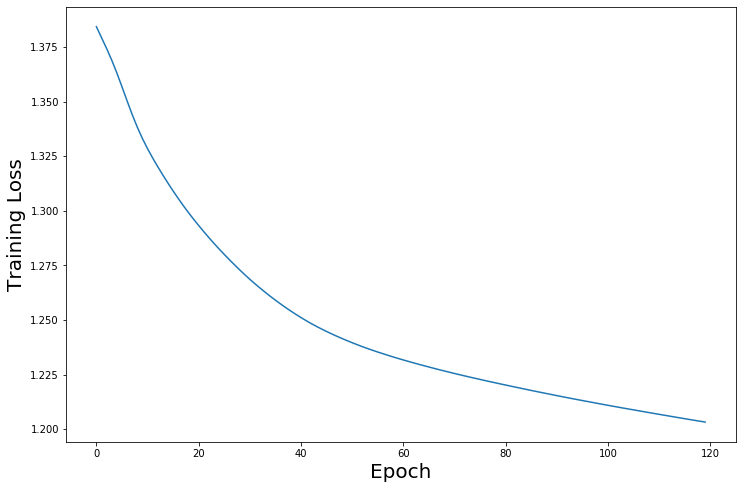

Using the Deep Neural Net from Task 5


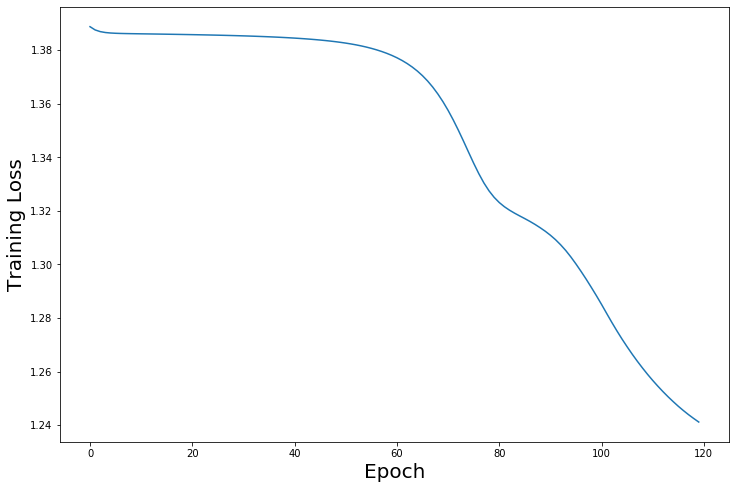

The architecture from Task 3 took 11.934s to train
The architecture from Task 5 took 12.457s to train


In [454]:

start = time.time()
print('Using the Neural Net from Task 3')
net3 = train_analysis(bdata)
time3 = round(time.time()-start, 3)


start = time.time()
print('Using the Deep Neural Net from Task 5')
deep = train_analysis(bdata, hidden_size=80, num_epochs=120, deep=True)
time5 = round(time.time()-start, 3)

print(f'The architecture from Task 3 took {time3}s to train')
print(f'The architecture from Task 5 took {time5}s to train')


Running for 120 epochs, we find that the Task 3 neural net seems to be close to converging. It also has a slightly lower loss than the deep net. On the other hand, the deepnet seems like it's not done training as the curve is still quite steep by epoch 120. They take a similar amount of time to run.

I wanted to try running both nets for more epochs but we don't have enough data. The risk of running too long is that our nets will end up overfitting a lot. As I mentioned, in the discussion in task 4, whilst the neural network does a good job for this classification task, we could get even better results with bigger datasets because we could train longer.

As it stands, the deep net is less performant. Making it better would require more time, and more data but I believe it would eventually outperform the normal task 3 net.


### **5.2** 
**(5 marks) Consider the NN model you implemented in Task 3. Optimise a NN with the same architecture as in Task 3 but changing the activation units from ReLU to Sigmoidal. Compare the performance of the ReLU and sigmoidal NNs and, specifically, their speed of convergence.**

Using sigmoid


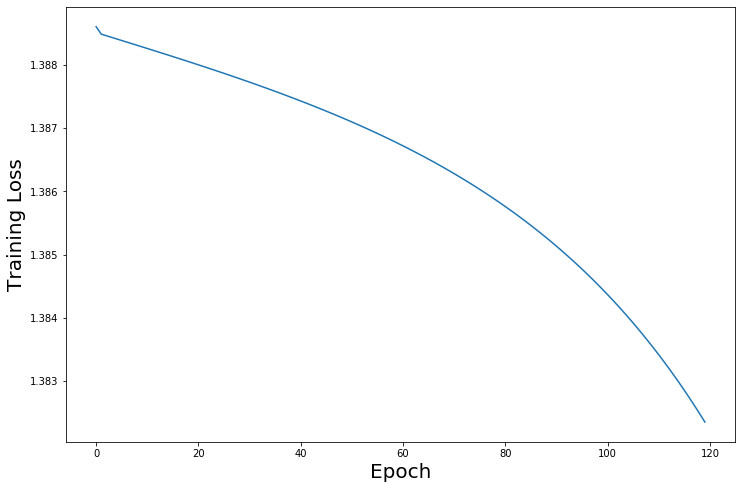

Using ReLU


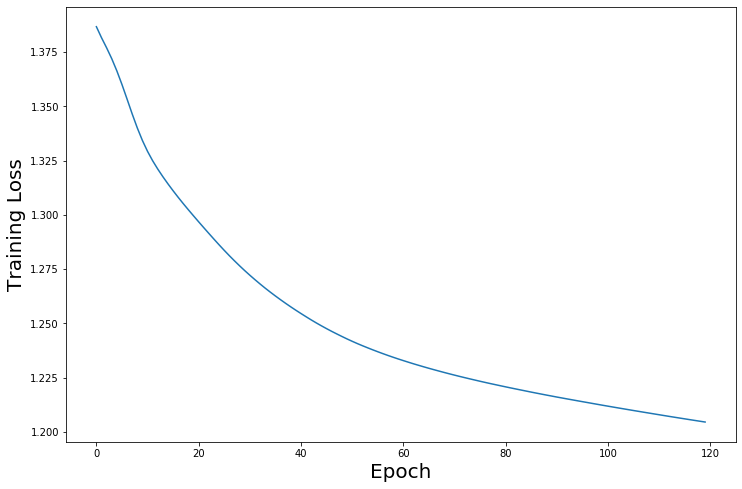

In [465]:
print('Using sigmoid')
net = train_analysis(bdata, func=torch.sigmoid)
print('Using ReLU')
net = train_analysis(bdata)

Sigmoid has a vanishing gradient problem. Each neuron gets a change in weight proportional to the partial derivatives. This is fine with ReLU because the gradient of the function is either 0, or 1 but the Sigmoid gradient tends to 0 for large or really small values. For that reason, the changes in weights will very often happen slowly, meaning the convergence will take a very long time. This is visible in the graphs: over 120 epochs, Sigmoid's training loss only decreases by 0.005 whereas ReLU's drops by nearly 0.175. 